# Initialize env

### Load libraries

In [2]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
!pip install fastapi[all]
import fastapi
from fastapi import FastAPI

In [4]:
!pip install uvicorn
import uvicorn

In [5]:
!pip install nest_asyncio
import nest_asyncio

In [6]:
!pip install python-multipart

In [7]:
from fastapi import Request
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates

In [9]:
!pip install librosa
import librosa
from sklearn.preprocessing import LabelEncoder

  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23694 sha256=ffd34adda8a4ac0f1c1762f2910c55e73ff4b58c81fdc1cf5bdb2403c2eb7564
  Stored in directory: c:\users\varun\appdata\local\pip\cache\wheels\0a\ed\be\49df2538fca496690a024a4374455584d65c2afd6fc3d6e9c7
Successfully built audioread


### Load saved model

In [10]:
model = keras.models.load_model("model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

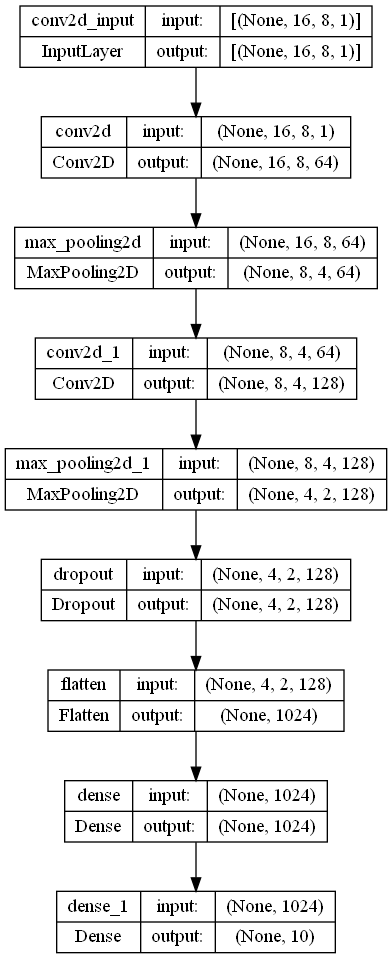

In [219]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=static_dir + 'templates/images/model_plot.png', show_shapes=True, show_layer_names=True)

### Configure labels

In [11]:
labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

### Configure paths

In [125]:
static_dir = "static/"
sample_sounds_zip = static_dir + "sample_sounds.zip"
uploads_dir = static_dir + "uploads/"
!@mkdir "static/uploads"

A subdirectory or file static/uploads already exists.


# Model methods

In [65]:
def parse(file):
    X, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
    return mels

In [66]:
def predict(file):
    features = parse(file)
    features = features.reshape(-1, 16, 8, 1)
    pred_vector = np.argmax(model.predict([features]), axis=-1)
    pred_class = labels[pred_vector[0]]
    return pred_class

In [67]:
for i in range(1, 8):
    print(predict(r"static/sample_sounds/" + str(i) + ".wav"))

1/1 [==============================] - 0s 18ms/step
gun_shot
1/1 [==============================] - 0s 16ms/step
car_horn
1/1 [==============================] - 0s 16ms/step
children_playing
1/1 [==============================] - 0s 18ms/step
dog_bark
1/1 [==============================] - 0s 17ms/step
jackhammer
1/1 [==============================] - 0s 18ms/step
engine_idling
1/1 [==============================] - 0s 21ms/step
drilling


# API Routes

### Configure FastAPI server

In [260]:
app = FastAPI()

app.mount("/static", StaticFiles(directory=static_dir), name="static")
templates = Jinja2Templates(directory="static/templates")

@app.get("/test")
async def test():
    return {"message": "Testing Endpoint"}

### Backend

In [261]:
from fastapi import File, UploadFile

@app.post("/upload")
def upload(file: UploadFile = File(...)):
    try:
        contents = file.file.read()
        with open(uploads_dir + file.filename, 'wb') as f:
            f.write(contents)
    except Exception:
        return {"message": "There was an error uploading the file"}
    finally:
        file.file.close()

    return {"message": predict(uploads_dir + file.filename)}

In [262]:
from fastapi.responses import FileResponse

@app.get("/download-samples")
def download_samples():
    res = FileResponse(path=sample_sounds_zip, filename="sample_sounds.zip", media_type='application/zip')
    res.headers['Access-Control-Expose-Headers'] = 'Content-Disposition'
    res.headers["Content-Disposition"] = "attachment; filename=sample_sounds.zip"
    return res

### Template serving

In [263]:
from fastapi import Request

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):
    return templates.TemplateResponse("home.html", {"request": request})

In [264]:
from fastapi import Request

@app.get("/sample-data", response_class=HTMLResponse)
async def sample_data(request: Request):
    return templates.TemplateResponse("sample_data.html", {"request": request})

In [265]:
from fastapi import Request

@app.get("/arch", response_class=HTMLResponse)
async def arch(request: Request):
    return templates.TemplateResponse("arch.html", {"request": request})

In [266]:
from fastapi import Request

@app.get("/about", response_class=HTMLResponse)
async def about(request: Request):
    return templates.TemplateResponse("about.html", {"request": request})

# Start server

In [267]:
nest_asyncio.apply()
uvicorn.run(app, port=8080)

INFO:     Started server process [4636]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8080 (Press CTRL+C to quit)


INFO:     127.0.0.1:63260 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:63260 - "GET /templates/styles.css HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:63260 - "POST /upload HTTP/1.1" 200 OK
1/1 [==============================] - 0s 21ms/step
INFO:     127.0.0.1:63260 - "POST /upload HTTP/1.1" 200 OK
INFO:     127.0.0.1:63267 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:63267 - "GET /templates/styles.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:63267 - "GET /templates/images/logo.png HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [4636]
